In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0K2MXZ/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0K2MXZ/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [10]:
dataset['train']

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [9]:
def preprocessImages(input_image, input_mask):
  input_image = input_image / 255.0
  input_mask -= 1
  return input_image, input_mask

In [11]:
def loadImages(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_image, input_mask = preprocessImages(input_image, input_mask)
  return input_image, input_mask

In [12]:
info.splits['train'].num_examples

3680

In [13]:
train_length = info.splits['train'].num_examples
batch_size = 64

In [44]:
train_images = dataset['train'].map(loadImages, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(loadImages, num_parallel_calls=tf.data.AUTOTUNE)

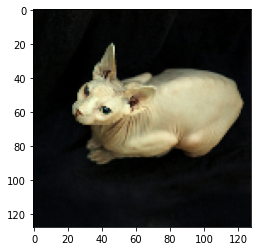

In [45]:
img, mask = train_images.take(2)
img = img[0]
mask = mask[0]
plt.imshow(tf.keras.utils.array_to_img(img))

In [64]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=10):
    super().__init__()
    self.augmented_input = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)
    self.augmented_lables = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)

  def call(self, inputs, labels):
    inputs = self.augmented_input(inputs)
    labels = self.augmented_lables(labels)
    return inputs, labels

In [65]:
def plotImages(images):
  plt.figure(figsize=(10,10))
  for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(tf.keras.utils.array_to_img(images[i]))
    plt.axis('off')
  plt.show()

In [66]:
# images, masks = train_images.take(2)
# img, mask = images[0], masks[0]
# plt.imshow(tf.keras.utils.array_to_img(img))

In [67]:
train_batches = (train_images).cache().shuffle(1000).batch(batch_size).repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE)

In [68]:
test_batches = test_images.batch(batch_size)

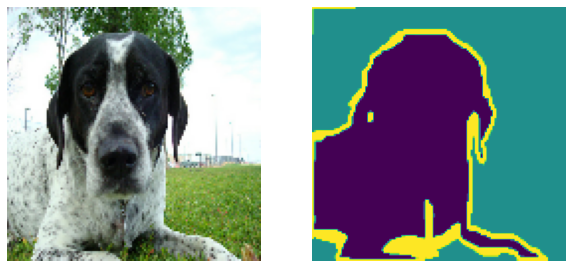

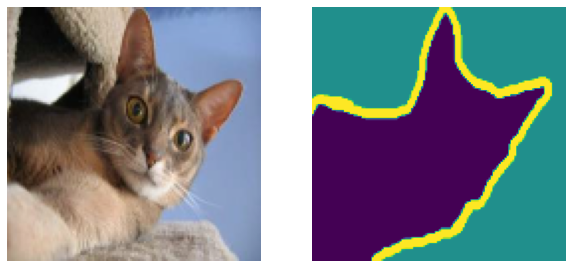

In [69]:
for images, masks in train_batches.take(2):
  img, mask = images[0], masks[0]
  imagesList = [img, mask]
  plotImages(imagesList)

In [70]:
from tensorflow.keras.applications import MobileNetV2

In [71]:
base_model = MobileNetV2(include_top=False, input_shape=(128,128,3))

9420800/9406464 [==============================] - 0s 0us/step


In [74]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [75]:
layer_names = [
               'block_1_expand_relu',
               'block_3_expand_relu',
               'block_6_expand_relu',
               'block_13_expand_relu',
               'block_16_project',

]

In [78]:
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

In [79]:
new_model = tf.keras.Model(inputs=base_model.input, outputs = base_model_outputs)

In [80]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         